In [1059]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     cross_validate)
%matplotlib inline 
from sklearn.feature_selection import mutual_info_classif
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [1060]:
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format','{:.2f}'.format)

In [1061]:
cr_hist = pd.read_parquet(r'D:\TrashFolder\cbu_code\credit_history.parquet')
geo = pd.read_xml(r'D:\TrashFolder\cbu_code\geographic_data.xml')
loan_det = pd.read_excel(r'D:\TrashFolder\cbu_code\loan_details.xlsx')
fin_rat = pd.read_json(r'D:\TrashFolder\cbu_code\financial_ratios.jsonl', lines=True)
app_data = pd.read_csv(r'D:\TrashFolder\cbu_code\application_metadata.csv')
demo = pd.read_csv(r'D:\TrashFolder\cbu_code\demographics.csv')

In [1062]:
total_df = demo.merge(app_data, how='outer',left_on='cust_id',right_on='customer_ref')\
    .merge(fin_rat, how='outer',left_on='cust_id',right_on='cust_num')\
    .merge(geo,how='outer',left_on='cust_id',right_on='id')\
    .merge(cr_hist, how='outer', left_on='cust_id', right_on='customer_number')\
    .merge(loan_det, how='outer', left_on='cust_id', right_on='customer_id')


In [1063]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89999 entries, 0 to 89998
Data columns (total 68 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cust_id                     89999 non-null  int64  
 1   age                         89999 non-null  int64  
 2   annual_income               89999 non-null  object 
 3   employment_length           87746 non-null  float64
 4   employment_type             89999 non-null  object 
 5   education                   89999 non-null  object 
 6   marital_status              89999 non-null  object 
 7   num_dependents              89999 non-null  int64  
 8   customer_ref                89999 non-null  int64  
 9   application_id              89999 non-null  int64  
 10  application_hour            89999 non-null  int64  
 11  application_day_of_week     89999 non-null  int64  
 12  account_open_year           89999 non-null  int64  
 13  preferred_contact           899

In [1064]:
drop_list = ['cust_id', 'customer_ref', 'application_id', 'id','customer_id', 'cust_num','customer_number','random_noise_1']

total_df = total_df[[x for x in total_df.columns if x not in drop_list]]

In [1065]:
total_df['annual_income'] = total_df['annual_income'].str.replace('$','').str.replace(',','').astype('float64')
total_df['employment_length'] = total_df['employment_length'].fillna(total_df['employment_length'].median())
ft_list = ['Full-time','FULL_TIME','Full Time', 'Fulltime','FT']
pt_list = ['Part Time','PART_TIME','PT','Part-time']
con_list = ['Contract','CONTRACT','Contractor']
se_list = ['Self Employed','Self Emp','Self-employed','SELF_EMPLOYED']

def employment_func(x):
    if x in ft_list:
        return 'FT'
    elif x in pt_list:
        return 'PT'
    elif x in con_list:
        return 'Contract'
    elif x in se_list:
        return 'SE'

total_df['employment_type'] = total_df['employment_type'].apply(employment_func)

total_df['monthly_income'] = total_df['monthly_income'].str.replace('$','').str.replace(',','').astype('float64')
total_df['monthly_payment'] = total_df['monthly_payment'].str.replace('$','').str.replace(',','').astype('float64')
total_df['existing_monthly_debt'] = total_df['existing_monthly_debt'].str.replace('$','').str.replace(',','').astype('float64')
total_df['revolving_balance'] = total_df['revolving_balance'].str.replace('$','').str.replace(',','').astype('float64')
for item in ['credit_usage_amount' ,'available_credit' , 'total_monthly_debt_payment','monthly_free_cash_flow' ,'total_debt_amount']:
    total_df[item] = total_df[item].str.replace('$','').str.replace(',','').astype('float64')  

C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\296312088.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  total_df['annual_income'] = total_df['annual_income'].str.replace('$','').str.replace(',','').astype('float64')
C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\296312088.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  total_df['monthly_income'] = total_df['monthly_income'].str.replace('$','').str.replace(',','').astype('float64')
C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\296312088.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *n

In [1066]:
total_df['revolving_balance'].fillna(total_df['revolving_balance'].median(), inplace=True)

In [1067]:
def loan_type_func(x):
    if x in ['Personal Loan','personal','PERSONAL','Personal']:
        return 'Personal'
    elif x in ['MORTGAGE','mortgage','Mortgage']:
        return 'Mortgage'
    elif x in ['Credit Card','CreditCard','credit card','CC']:
        return 'credit_card'
    else:
        return 'Home Loan'
total_df['loan_type'] = total_df['loan_type'].apply(loan_type_func)

In [1068]:
total_df['num_delinquencies_2yrs'] = total_df['num_delinquencies_2yrs'].fillna(0)
total_df['loan_amount'] = total_df['loan_amount'].str.replace('$','').str.replace(',','').astype('float64')

C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\1295929834.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  total_df['loan_amount'] = total_df['loan_amount'].str.replace('$','').str.replace(',','').astype('float64')


In [1069]:
total_df

,age,annual_income,employment_length,employment_type,education,marital_status,num_dependents,application_hour,application_day_of_week,account_open_year,preferred_contact,referral_code,account_status_code,num_login_sessions,num_customer_service_calls,has_mobile_app,paperless_billing,default,monthly_income,existing_monthly_debt,monthly_payment,debt_to_income_ratio,debt_service_ratio,payment_to_income_ratio,credit_utilization,revolving_balance,credit_usage_amount,available_credit,total_monthly_debt_payment,annual_debt_payment,loan_to_annual_income,total_debt_amount,monthly_free_cash_flow,state,regional_unemployment_rate,regional_median_income,regional_median_rent,housing_price_index,cost_of_living_index,previous_zip_code,credit_score,num_credit_accounts,oldest_credit_line_age,oldest_account_age_months,total_credit_limit,num_delinquencies_2yrs,num_inquiries_6mo,recent_inquiry_count,num_public_records,num_collections,account_diversity_index,loan_type,loan_amount,loan_term,interest_rate,loan_purpose,loan_to_value_ratio,origination_channel,loan_officer_id,marketing_campaign
0,41,61800.00,2.20,FT,Graduate,Married,2,5,6,2013,Mail,REF0000,ACT-2,13,2,1,1,0,5150.00,738.64,592.13,0.26,0.26,0.12,0.84,142213.10,142213.10,26886.90,1330.77,15969.24,0.29,159913.10,3819.23,OH,4.80,56000,1380.00,91.00,73.00,451,696,14,22.80,273.60,169100.00,0.00,2,2,1,0,0.50,Personal,17700.00,36,12.50,Debt Consolidation,0.00,Direct Mail,1045,W
1,38,28600.00,7.00,FT,High School,Married,0,4,2,2015,Phone,REF0000,ACT-3,6,1,1,1,1,2383.33,392.21,1013.86,0.59,0.59,0.42,0.97,75932.20,75932.20,2267.80,1406.07,16872.84,3.99,189932.20,977.26,PA,4.40,61000,1510.00,92.00,87.00,537,659,13,3.50,42.00,78200.00,0.00,6,6,0,0,0.30,Mortgage,114000.00,180,6.83,Refinance,0.77,Branch,1011,B
2,18,20700.00,0.80,FT,Bachelor,Single,0,10,3,2020,Phone,REF0000,ACT-3,1,2,1,0,0,1725.00,204.07,317.81,0.30,0.30,0.18,0.54,22314.60,22314.60,19085.40,521.88,6262.56,0.45,31614.60,1203.12,VA,3.90,74000,1920.00,125.00,103.00,679,662,3,0.00,0.00,41400.00,0.00,2,2,0,0,0.17,Personal,9300.00,36,13.99,Major Purchase,0.00,Online,1084,K
3,27,31400.00,4.80,FT,Bachelor,Single,0,7,5,2010,Email,REF0000,A01,4,1,1,1,0,2616.67,288.71,234.52,0.20,0.20,0.09,0.15,8820.00,8820.00,51180.00,523.23,6278.76,0.28,17520.00,2093.44,CA,5.80,75000,1690.00,158.00,121.00,719,676,8,9.00,108.00,60000.00,0.00,1,1,0,0,0.26,Personal,8700.00,48,13.26,Medical,0.00,Online,1048,A
4,26,24600.00,5.20,FT,High School,Single,0,1,2,2020,Mail,REF0000,ACT-3,6,2,1,0,0,2050.00,248.77,334.81,0.29,0.28,0.16,0.49,24253.60,24253.60,25446.40,583.58,7002.96,0.29,31453.60,1466.42,WA,5.80,78000,1700.00,152.00,127.00,933,678,7,8.00,96.00,49700.00,0.00,1,1,0,0,0.30,Personal,7200.00,24,10.77,Debt Consolidation,0.00,Branch,1055,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89994,52,72300.00,3.70,FT,Bachelor,Single,1,13,5,2016,Email,REF0000,A01,10,3,0,1,0,6025.00,2120.97,519.87,0.44,0.44,0.09,0.36,48680.40,48680.40,86919.60,2640.84,31690.08,0.16,59980.40,3384.16,CA,5.80,75000,1830.00,168.00,138.00,933,817,10,8.20,98.40,135600.00,0.00,1,1,0,0,0.28,Personal,11300.00,24,9.70,Home Improvement,0.00,Branch,1050,O
89995,61,20000.00,4.20,FT,High School,Divorced,1,13,5,2014,Mail,REF9754,ACTIVE,12,1,1,0,0,1666.67,138.97,545.44,0.41,0.41,0.33,0.35,15833.00,15833.00,28767.00,684.41,8212.92,0.83,32333.00,982.26,IL,4.90,65000,1900.00,99.00,84.00,536,745,9,8.80,105.60,44600.00,0.00,1,1,0,0,0.35,Personal,16500.00,36,11.67,Other,0.00,Branch,1071,D
89996,19,20000.00,1.50,FT,High School,Married,3,7,5,2010,Mail,REF0000,A01,4,2,1,1,1,1666.67,129.90,616.96,0.45,0.45,0.37,0.67,12242.70,12242.70,6057.30,746.86,8962.32,0.89,30042.70,919.81,CA,5.40,75000,1560.00,157.00,127.00,193,607,11,1.00,12.00,18300.00,0.00,2,2,1,0,0.24,Personal,17800.00,36,14.99,Major Purchase,0.00,Online,1046,J
89997,2

In [1070]:
total_df['num_dependents'] = np.where(total_df['num_dependents']>2,2,total_df['num_dependents'])

In [1071]:
t = total_df.groupby(by='referral_code')['default'].sum() / total_df.groupby(by='referral_code')['default'].count()

In [1072]:
t = t[t>0.1].index

In [1073]:
#total_df['referral_code'] = total_df['referral_code'].apply(lambda x: x if x in t else 'OTHER')
total_df['bad_ref'] = total_df['referral_code'].apply(lambda x: 1 if x in t else 0)
total_df['num_customer_service_calls'] = np.where(total_df['num_customer_service_calls']>3,3,total_df['num_customer_service_calls'])
total_df['employment_length'] = np.where(total_df['employment_length'] > 8,8,total_df['employment_length'])
total_df['num_login_sessions'] = np.where(total_df['num_login_sessions']>13,13,total_df['num_login_sessions'])
for col in ['loan_to_annual_income','payment_to_income_ratio','credit_utilization','debt_service_ratio','debt_to_income_ratio','loan_to_value_ratio']:
    total_df[col] = np.where(total_df[col]>np.percentile(total_df[col],85), np.percentile(total_df[col],85),total_df[col])



In [1074]:
np.percentile(total_df['num_login_sessions'],85)

13.0

<Axes: >

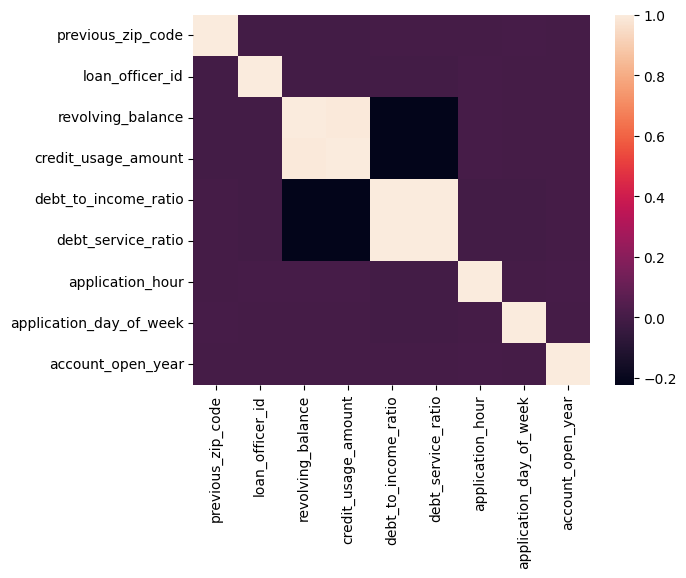

In [1075]:
sns.heatmap(total_df[['previous_zip_code','loan_officer_id','revolving_balance','credit_usage_amount','debt_to_income_ratio'\
          ,'debt_service_ratio','application_hour','application_day_of_week','account_open_year']].corr())

In [1076]:
total_df = total_df.drop(columns=['revolving_balance','debt_service_ratio'], axis=1)
total_df['monthly_free_cash_flow'] = np.where(total_df['monthly_free_cash_flow']<0,0,total_df['monthly_free_cash_flow'])
cat_cols = ['application_hour','application_day_of_week','account_open_year','previous_zip_code','loan_term','loan_officer_id']

for col in cat_cols:
    total_df[col] = total_df[col].apply(lambda x: f'{x}_categ')

money_cols = ['annual_income','monthly_income','existing_monthly_debt','monthly_payment','credit_usage_amount','available_credit'\
              ,'total_monthly_debt_payment','annual_debt_payment','total_debt_amount','monthly_free_cash_flow','regional_median_income'\
              ,'regional_median_rent','total_credit_limit','loan_amount']
for col in money_cols:
    total_df[col] = np.log(total_df[col]+0.01)

total_df['loan_to_value_ratio'] = np.where(total_df['loan_to_value_ratio']>0.7,0.7,total_df['loan_to_value_ratio'])


In [1077]:
for col in cat_cols:
    total_df[col] = total_df[col].apply(lambda x: f'{x}_categ')

In [1078]:
prob_ed = total_df.groupby('education', as_index=False)['default'].mean()
prob_mar = total_df.groupby('marital_status', as_index=False)['default'].mean()

In [1079]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = {}
X = total_df.drop('default',axis=1)
y = total_df['default']

def cv_column_score(X, y, col, n_splits=5):
    """
    Обучает CatBoost только на одном столбце
    и считает средний roc_auc по cross-val.
    Автоматически определяет, является ли столбец категориальным.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # определяем тип признака
    is_cat = X[col].dtype == "object" or str(X[col].dtype).startswith("category")

    scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train = X.iloc[train_idx][[col]]
        X_val   = X.iloc[val_idx][[col]]
        y_train = y.iloc[train_idx]
        y_val   = y.iloc[val_idx]

        model = CatBoostClassifier(
            depth=6,
            learning_rate=0.05,
            iterations=400,
            verbose=False,
            loss_function="Logloss",random_seed=123
        )

        model.fit(
            X_train,
            y_train,
            cat_features=[0] if is_cat else None   # <-- ВАЖНО
        )

        preds = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, preds)
        scores.append(score)

    return np.mean(scores), np.std(scores)

In [882]:
results = []

for col in X.columns:
    mean_score, std_score = cv_column_score(X, y, col)
    results.append((col, mean_score, std_score))
    print(col)
    
df_fi = pd.DataFrame(results, columns=["feature", "roc_auc_mean", "roc_auc_std"])
df_fi = df_fi.sort_values("roc_auc_mean", ascending=False)

print(df_fi)

KeyboardInterrupt: 

In [1080]:
categorical_features = total_df.select_dtypes(include='object').columns
for col in categorical_features:
    distribution = total_df.groupby(col)['default'].value_counts(normalize=True).unstack()
    print(f"\nFeature: {col}")
    print(distribution)



Feature: employment_type
default            0    1
employment_type          
Contract        0.94 0.06
FT              0.95 0.05
PT              0.95 0.05
SE              0.95 0.05

Feature: education
default         0    1
education             
Advanced     0.97 0.03
Bachelor     0.96 0.04
Graduate     0.97 0.03
High School  0.91 0.09
Some College 0.94 0.06

Feature: marital_status
default           0    1
marital_status          
Divorced       0.96 0.04
Married        0.96 0.04
Single         0.93 0.07

Feature: application_hour
default             0    1
application_hour          
0_categ_categ    0.95 0.05
10_categ_categ   0.95 0.05
11_categ_categ   0.95 0.05
12_categ_categ   0.95 0.05
13_categ_categ   0.95 0.05
14_categ_categ   0.95 0.05
15_categ_categ   0.95 0.05
16_categ_categ   0.95 0.05
17_categ_categ   0.95 0.05
18_categ_categ   0.95 0.05
19_categ_categ   0.94 0.06
1_categ_categ    0.96 0.04
20_categ_categ   0.95 0.05
21_categ_categ   0.95 0.05
22_categ_categ   0.95 0.05
2

In [1081]:
drop_cols = ['employment_type','application_hour','application_day_of_week','account_open_year','preferred_contact','account_status_code','state',\
            'origination_channel','loan_officer_id','marketing_campaign']
total_df = total_df.drop(columns=drop_cols,axis=1)
total_df['oldest_credit_line_age'] = np.where(total_df['oldest_credit_line_age']>14,14,total_df['oldest_credit_line_age'])
total_df['oldest_credit_line_age'] = pd.qcut(total_df['oldest_credit_line_age'],4)
total_df['oldest_account_age_months'] = pd.qcut(total_df['oldest_account_age_months'],5)
total_df['interest_rate'] = pd.qcut(total_df['interest_rate'],5)
total_df['payment_to_income_ratio'] = pd.qcut(total_df['payment_to_income_ratio'],5)
total_df['credit_utilization'] = pd.qcut(total_df['credit_utilization'],5)
total_df['problem_education'] = np.where((total_df.groupby('education')['default'].transform(lambda x: x.mean())>0.05),1,0)
total_df['problem_maritial'] = np.where((total_df.groupby('marital_status')['default'].transform(lambda x: x.mean())>0.05),1,0)

In [1082]:
#О случайному лесу определили fI фичей также по Catboost FI

feature_cols = ['credit_score','monthly_free_cash_flow','monthly_income','annual_income','bad_ref','age','debt_to_income_ratio'\
                ,'total_credit_limit','payment_to_income_ratio','available_credit','loan_to_annual_income','existing_monthly_debt',\
                'num_login_sessions','monthly_payment','credit_usage_amount','loan_amount','annual_debt_payment','num_credit_accounts',\
                'total_monthly_debt_payment','total_debt_amount','account_diversity_index','credit_utilization','oldest_credit_line_age'\
                ,'oldest_account_age_months','education','loan_to_value_ratio','marital_status','loan_term','cost_of_living_index','housing_price_index'\
                ,'regional_unemployment_rate','regional_median_rent','interest_rate','loan_type','employment_length','problem_maritial','problem_education']
                

In [1083]:
new_df = total_df[feature_cols]

cc_cols = [

    ('oldest_credit_line_age','interest_rate'),
    ('credit_utilization','education'),
    ('credit_score', 'marital_status'),
    ('loan_term','interest_rate')
]

for col1, col2 in cc_cols:
    new_df[col1 +'+'+col2] = new_df[col1].astype(str) + '_+_' + new_df[col2].astype(str)

C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\3511307307.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col1 +'+'+col2] = new_df[col1].astype(str) + '_+_' + new_df[col2].astype(str)
C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\3511307307.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col1 +'+'+col2] = new_df[col1].astype(str) + '_+_' + new_df[col2].astype(str)
C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\3511307307.py:12: SettingWithCopyWarning: 
A valu

In [1084]:
new_df['credit_score_sq'] = new_df['credit_score']**2

C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\491387290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['credit_score_sq'] = new_df['credit_score']**2


In [1085]:
X = pd.get_dummies(new_df)
X_train, X_test, y_train, y_test = train_test_split(X, total_df['default'], test_size=0.3, random_state=123, stratify=y)


In [1086]:
num_cols = new_df.select_dtypes(include='number').columns
for col in num_cols:
    if col in (['problem_education','problem_maritial']):
        continue
    mn = X_train[col].mean()
    std = X_train[col].std()
    X_train[col] = (X_train[col] - mn)/std
    X_test[col] = (X_test[col] - mn)/std

In [1087]:
X_train.shape, X_test.shape

((62999, 996), (27000, 996))

In [1088]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    max_features='sqrt',
    class_weight={0:1, 1:15},  # усиливаем редкий класс (~5%)
    n_jobs=-1,
    random_state=42
)

roc_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='roc_auc')

In [1089]:
np.mean(roc_scores)

0.8057143163727863

In [1090]:
clf = LogisticRegression(
    class_weight='balanced',  # усиливаем редкий класс
    solver='liblinear',        # хорошо работает для маленьких и средних датасетов
    max_iter=2000,
    random_state=42,C=0.1
)

roc_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc')

In [1091]:
np.mean(roc_scores)

0.8188075396583081

In [1092]:
cb = CatBoostClassifier(iterations=300, learning_rate=0.1, l2_leaf_reg=7, depth=4, class_weights={0:1,1:15},bagging_temperature=0.5, loss_function='Logloss',
    verbose=0,
    random_state=42)
roc_scores = cross_val_score(cb, X_train, y_train, cv=cv, scoring='roc_auc')

In [1093]:
np.mean(roc_scores)

0.8297018097713554

In [1094]:
cb = CatBoostClassifier(iterations=300, learning_rate=0.1, l2_leaf_reg=7, depth=4, class_weights={0:1,1:15},bagging_temperature=0.5, loss_function='Logloss',
    verbose=0,
    random_state=42)

num_cols = new_df.select_dtypes(include='number').columns
for col in num_cols:
    if col in (['problem_education','problem_maritial']):
        continue
    mn = X[col].mean()
    std = X[col].std()
    X[col] = (X[col] - mn)/std

In [1095]:
#Обучаем модель
pca = PCA(n_components=59, random_state=42)
X_transformed = pca.fit_transform(X)

cb.fit(X_transformed, y)

In [1096]:
print('f1_score:',f1_score(y, np.where(cb.predict_proba(X_transformed)[:,1]>0.72,1,0)))
print('roc_auc_score:',roc_auc_score(y, cb.predict_proba(X_transformed)[:,1]))

f1_score: 0.4010287673842637
roc_auc_score: 0.8826910408209678


In [1097]:
#ЭВАЛ СЕТ 

cr_hist = pd.read_parquet(r'D:\TrashFolder\cbu_code\evaluation_set\credit_history.parquet')
geo = pd.read_xml(r'D:\TrashFolder\cbu_code\evaluation_set\geographic_data.xml')
loan_det = pd.read_excel(r'D:\TrashFolder\cbu_code\evaluation_set\loan_details.xlsx')
fin_rat = pd.read_json(r'D:\TrashFolder\cbu_code\evaluation_set\financial_ratios.jsonl', lines=True)
app_data = pd.read_csv(r'D:\TrashFolder\cbu_code\evaluation_set\application_metadata.csv')
demo = pd.read_csv(r'D:\TrashFolder\cbu_code\evaluation_set\demographics.csv')

In [1098]:
total_df = demo.merge(app_data, how='outer',left_on='cust_id',right_on='customer_ref')\
    .merge(fin_rat, how='outer',left_on='cust_id',right_on='cust_num')\
    .merge(geo,how='outer',left_on='cust_id',right_on='id')\
    .merge(cr_hist, how='outer', left_on='cust_id', right_on='customer_number')\
    .merge(loan_det, how='outer', left_on='cust_id', right_on='customer_id')


In [1099]:
ans_df = total_df[['cust_id']]

In [1100]:
drop_list = ['cust_id', 'customer_ref', 'application_id', 'id','customer_id', 'cust_num','customer_number','random_noise_1']

total_df = total_df[[x for x in total_df.columns if x not in drop_list]]

total_df['annual_income'] = total_df['annual_income'].str.replace('$','').str.replace(',','').astype('float64')
total_df['employment_length'] = total_df['employment_length'].fillna(total_df['employment_length'].median())
ft_list = ['Full-time','FULL_TIME','Full Time', 'Fulltime','FT']
pt_list = ['Part Time','PART_TIME','PT','Part-time']
con_list = ['Contract','CONTRACT','Contractor']
se_list = ['Self Employed','Self Emp','Self-employed','SELF_EMPLOYED']

def employment_func(x):
    if x in ft_list:
        return 'FT'
    elif x in pt_list:
        return 'PT'
    elif x in con_list:
        return 'Contract'
    elif x in se_list:
        return 'SE'

total_df['employment_type'] = total_df['employment_type'].apply(employment_func)

total_df['monthly_income'] = total_df['monthly_income'].str.replace('$','').str.replace(',','').astype('float64')
total_df['monthly_payment'] = total_df['monthly_payment'].str.replace('$','').str.replace(',','').astype('float64')
total_df['existing_monthly_debt'] = total_df['existing_monthly_debt'].str.replace('$','').str.replace(',','').astype('float64')
total_df['revolving_balance'] = total_df['revolving_balance'].str.replace('$','').str.replace(',','').astype('float64')
for item in ['credit_usage_amount' ,'available_credit' , 'total_monthly_debt_payment','monthly_free_cash_flow' ,'total_debt_amount']:
    total_df[item] = total_df[item].str.replace('$','').str.replace(',','').astype('float64')  

C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\989808047.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  total_df['annual_income'] = total_df['annual_income'].str.replace('$','').str.replace(',','').astype('float64')
C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\989808047.py:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  total_df['monthly_income'] = total_df['monthly_income'].str.replace('$','').str.replace(',','').astype('float64')
C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\989808047.py:25: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *n

In [1101]:
total_df['revolving_balance'].fillna(total_df['revolving_balance'].median(), inplace=True)
total_df['loan_type'] = total_df['loan_type'].apply(loan_type_func)
total_df['num_delinquencies_2yrs'] = total_df['num_delinquencies_2yrs'].fillna(0)
total_df['loan_amount'] = total_df['loan_amount'].str.replace('$','').str.replace(',','').astype('float64')

C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\1421059504.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  total_df['loan_amount'] = total_df['loan_amount'].str.replace('$','').str.replace(',','').astype('float64')


In [1102]:
total_df['num_dependents'] = np.where(total_df['num_dependents']>2,2,total_df['num_dependents'])
#total_df['referral_code'] = total_df['referral_code'].apply(lambda x: x if x in t else 'OTHER')
total_df['bad_ref'] = total_df['referral_code'].apply(lambda x: 1 if x in t else 0)
total_df['num_customer_service_calls'] = np.where(total_df['num_customer_service_calls']>3,3,total_df['num_customer_service_calls'])
total_df['employment_length'] = np.where(total_df['employment_length'] > 8,8,total_df['employment_length'])
total_df['num_login_sessions'] = np.where(total_df['num_login_sessions']>13,13,total_df['num_login_sessions'])
for col in ['loan_to_annual_income','payment_to_income_ratio','credit_utilization','debt_service_ratio','debt_to_income_ratio','loan_to_value_ratio']:
    total_df[col] = np.where(total_df[col]>np.percentile(total_df[col],85), np.percentile(total_df[col],85),total_df[col])



In [1103]:
total_df = total_df.drop(columns=['revolving_balance','debt_service_ratio'], axis=1)
total_df['monthly_free_cash_flow'] = np.where(total_df['monthly_free_cash_flow']<0,0,total_df['monthly_free_cash_flow'])
cat_cols = ['application_hour','application_day_of_week','account_open_year','previous_zip_code','loan_term','loan_officer_id']

for col in cat_cols:
    total_df[col] = total_df[col].apply(lambda x: f'{x}_categ')

money_cols = ['annual_income','monthly_income','existing_monthly_debt','monthly_payment','credit_usage_amount','available_credit'\
              ,'total_monthly_debt_payment','annual_debt_payment','total_debt_amount','monthly_free_cash_flow','regional_median_income'\
              ,'regional_median_rent','total_credit_limit','loan_amount']
for col in money_cols:
    total_df[col] = np.log(total_df[col]+0.01)

total_df['loan_to_value_ratio'] = np.where(total_df['loan_to_value_ratio']>0.7,0.7,total_df['loan_to_value_ratio'])


In [1104]:
total_df = total_df.merge(prob_ed, how='left').rename(columns={'default':'problem_education'}).merge(prob_mar,how='left').rename(columns={'default':'problem_maritial'})

In [1105]:
total_df

,age,annual_income,employment_length,employment_type,education,marital_status,num_dependents,application_hour,application_day_of_week,account_open_year,preferred_contact,referral_code,account_status_code,num_login_sessions,num_customer_service_calls,has_mobile_app,paperless_billing,monthly_income,existing_monthly_debt,monthly_payment,debt_to_income_ratio,payment_to_income_ratio,credit_utilization,credit_usage_amount,available_credit,total_monthly_debt_payment,annual_debt_payment,loan_to_annual_income,total_debt_amount,monthly_free_cash_flow,state,regional_unemployment_rate,regional_median_income,regional_median_rent,housing_price_index,cost_of_living_index,previous_zip_code,credit_score,num_credit_accounts,oldest_credit_line_age,oldest_account_age_months,total_credit_limit,num_delinquencies_2yrs,num_inquiries_6mo,recent_inquiry_count,num_public_records,num_collections,account_diversity_index,loan_type,loan_amount,loan_term,interest_rate,loan_purpose,loan_to_value_ratio,origination_channel,loan_officer_id,marketing_campaign,bad_ref,problem_education,problem_maritial
0,57,10.86,8.00,SE,Some College,Divorced,0,21_categ,0_categ,2018_categ,Email,REF0000,ACT-1,12,2,0,0,8.38,6.93,6.26,0.35,0.12,0.35,10.82,11.42,7.34,9.83,0.22,11.02,7.94,TN,4.10,10.88,7.24,99.00,73.00,390_categ,770,8,1.50,18.00,11.85,0.00,1,1,0,0,0.25,Personal,9.33,24_categ,10.26,Debt Consolidation,0.00,Online,1066_categ,T,0,0.06,0.04
1,41,10.73,5.50,SE,High School,Married,1,9_categ,6_categ,2021_categ,Phone,REF0000,ACT-1,10,3,0,1,8.24,7.10,5.32,0.37,0.05,0.28,10.15,11.08,7.25,9.74,0.15,10.38,7.78,CA,5.60,11.23,7.37,161.00,130.00,292_categ,733,7,14.60,175.20,11.41,0.00,1,1,0,0,0.28,credit_card,8.82,0_categ,17.74,Revolving Credit,0.00,Branch,1041_categ,B,0,0.09,0.04
2,22,9.90,4.40,PT,Graduate,Single,1,10_categ,4_categ,2019_categ,Phone,REF0000,ACT-1,4,3,1,1,7.42,5.56,4.63,0.22,0.06,0.38,9.41,9.91,5.89,8.38,0.17,9.66,7.17,NY,4.90,11.18,7.46,138.00,118.00,552_categ,660,0,4.00,48.00,10.39,0.00,5,5,0,1,0.05,credit_card,8.13,0_categ,19.42,Revolving Credit,0.00,Online,1001_categ,W,0,0.03,0.07
3,27,10.70,8.00,FT,High School,Single,1,3_categ,4_categ,2011_categ,Email,REF0000,ACT-2,7,0,1,0,8.21,7.02,5.89,0.40,0.10,0.36,9.57,10.12,7.30,9.78,0.27,10.18,7.70,MA,4.00,11.30,7.48,140.00,116.00,716_categ,605,14,9.00,108.00,10.57,0.00,0,0,0,0,0.35,credit_card,9.39,0_categ,20.95,Revolving Credit,0.00,Online,1098_categ,D,0,0.09,0.07
4,32,10.62,0.90,FT,Bachelor,Single,2,9_categ,1_categ,2021_categ,Email,REF0000,ACT-1,6,0,1,0,8.14,6.57,7.53,0.75,0.54,0.49,10.06,10.10,7.85,10.34,6.81,12.62,6.75,IL,4.80,11.08,7.33,96.00,86.00,559_categ,721,5,8.70,104.40,10.78,0.00,2,2,1,0,0.24,Mortgage,12.54,360_categ,6.99,Refinance,0.70,Online,1067_categ,H,0,0.04,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,38,10.39,8.00,FT,Some College,Married,1,11_categ,6_categ,2020_categ,Email,REF0000,ACTIVE,7,2,0,1,7.91,5.49,7.38,0.68,0.58,0.64,9.69,9.13,7.52,10.00,7.00,12.58,6.77,PA,4.70,11.02,7.29,93.00,74.00,251_categ,688,12,14.20,170.40,10.14,1.00,4,4,0,0,0.34,Mortgage,12.52,360_categ,5.72,Refinance,0.70,Broker,1015_categ,L,0,0.06,0.04
9997,33,10.21,4.50,SE,Graduate,Single,2,16_categ,5_categ,2018_categ,Email,REF0000,ACTIVE,6,3,1,1,7.72,6.02,5.94,0.35,0.17,0.64,10.57,9.88,6.67,9.16,0.30,10.76,7.29,TX,4.40,11.02,7.37,104.00,93.00,532_categ,747,5,0.60,7.20,10.98,0.00,3,3,0,0,0.13,Personal,9.01,24_categ,10.36,Major Purchase,0.00,Branch,1000_categ,E,0,0.03,0.07
9998,20,10.06,2.90,FT,Some College,Single,1,3_categ,0_categ,2014_categ,Phone,REF0000,ACTIVE,4,1,1,0,7.58,6.00,6.14,0.45,0.24,0.56,10.22,10.00,6.77,9.25,0.76,10.72,6.99,PA,4.50,11.02,7.37,101.00,95.00,480_categ,694,10,2.00,24.00,10.81,1.00,1,1,1,0,0.29,Personal,9.78,48_categ,11.59,Major Purchase,0.00,Branch,1011_categ,F,0,0.06,0.07
9999,31,10.46,7.30,FT,Some Colle

In [1106]:
drop_cols = ['employment_type','application_hour','application_day_of_week','account_open_year','preferred_contact','account_status_code','state',\
            'origination_channel','loan_officer_id','marketing_campaign']
total_df = total_df.drop(columns=drop_cols,axis=1)
total_df['oldest_credit_line_age'] = np.where(total_df['oldest_credit_line_age']>14,14,total_df['oldest_credit_line_age'])
total_df['oldest_credit_line_age'] = pd.qcut(total_df['oldest_credit_line_age'],4)
total_df['oldest_account_age_months'] = pd.qcut(total_df['oldest_account_age_months'],5)
total_df['interest_rate'] = pd.qcut(total_df['interest_rate'],5)
total_df['payment_to_income_ratio'] = pd.qcut(total_df['payment_to_income_ratio'],5)
total_df['credit_utilization'] = pd.qcut(total_df['credit_utilization'],5)
#total_df['problem_education'] = np.where((total_df.groupby('education')['default'].transform(lambda x: x.mean())>0.05),1,0)
#total_df['problem_maritial'] = np.where((total_df.groupby('marital_status')['default'].transform(lambda x: x.mean())>0.05),1,0)

In [1107]:
new_df = total_df[feature_cols]

cc_cols = [

    ('oldest_credit_line_age','interest_rate'),
    ('credit_utilization','education'),
    ('credit_score', 'marital_status'),
    ('loan_term','interest_rate')
]

for col1, col2 in cc_cols:
    new_df[col1 +'+'+col2] = new_df[col1].astype(str) + '_+_' + new_df[col2].astype(str)

C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\3511307307.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col1 +'+'+col2] = new_df[col1].astype(str) + '_+_' + new_df[col2].astype(str)
C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\3511307307.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col1 +'+'+col2] = new_df[col1].astype(str) + '_+_' + new_df[col2].astype(str)
C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\3511307307.py:12: SettingWithCopyWarning: 
A valu

In [1108]:
new_df['credit_score_sq'] = new_df['credit_score']**2


C:\Users\xasanov.ay\AppData\Local\Temp\ipykernel_16244\1041425933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['credit_score_sq'] = new_df['credit_score']**2


In [1109]:
X_ans = pd.get_dummies(new_df)

In [1110]:
X_ans_trans = pca.fit_transform(X_ans)

In [1111]:
ans_df['proba'] = cb.predict_proba(pca.fit_transform(X_ans_trans))[:,1]

In [1112]:
ans_df['class'] = np.where(ans_df['proba']>0.72,1,0)

In [1114]:
ans_df.rename(columns={'cust_id':'customer_id','proba':'prob','class':'default'}).to_csv(r'D:\TrashFolder\cbu_code\results.csv',index=False)

0.3755624437556244